In [1]:
import os
import time
import copy
import torch
import torch.optim
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score 
import torchvision.models as models
!pip install livelossplot --quiet
from livelossplot import PlotLosses
from torch.optim import lr_scheduler
from matplotlib import text
import matplotlib.pyplot as plt
from skimage import io, transform
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#directory contains images
PATH = '/content/drive/Shareddrives/COMP576/dataset/Images'
# train-validation-test ratio
TRAIN = 0.7
VALID = 0.2
TEST = 0.1

# model parameters
size = 224
batch_size = 32
n_epochs = 20
step_size = 50

In [5]:
c_list = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel',
                  'Red Mullet', 'Red Sea Bream', 'Sea Bass',
                  'Shrimp', 'Striped Red Mullet', 'Trout']


In [6]:
data = pd.read_csv("/content/drive/Shareddrives/COMP576/dataset/filename_aug.csv")

# Image Augmentation (no need to rerun)

In [ ]:
for fn in data.iterrows():
  print(fn[1].filename + fn[1].trueLabel )
  break

Black Sea Sprat0000.pngBlack Sea Sprat


In [ ]:
!pip install wand

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get install libmagickwand-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmagickwand-dev is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.14).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [ ]:
from wand.image import Image
from multiprocessing import Pool
import os.path

In [7]:
data

,filename,trueLabel
0,Black Sea Sprat0000.png,Black Sea Sprat
1,Black Sea Sprat0001.png,Black Sea Sprat
2,Black Sea Sprat0002.png,Black Sea Sprat
3,Black Sea Sprat0003.png,Black Sea Sprat
4,Black Sea Sprat0004.png,Black Sea Sprat
...,...,...
23395,Distort_arc_Trout0099.png,Trout
23396,Distort_affine_Trout0099.png,Trout
23397,Charcoal_Trout0099.png,Trout
23398,Sketch_Trout0099.png,Trout


In [ ]:
def task(fd):
  global data
  fn = fd[1].filename
  if "Addnoise_" in fn:
    return
  fl = fd[1].trueLabel
  with Image(filename = PATH + "/" + fn) as img:
    #img.save(filename = PATH2 + "/" + fn)
    for iz in range(10):
      img.noise("gaussian", attenuate = 1.0)
    img.save(filename = PATH + "/Addnoise_" + fn)
    # data.append({'filename': "Addnoise_" + fn,'trueLabel': fl}, ignore_index=True)
  print("finish" + fn )
  
#pool = Pool()                        
#pool.map(task, data.iterrows())

In [ ]:
from wand.color import Color
distort_list = [ 'affine', 'affine_projection',
                'scale_rotate_translate','perspective',
                'perspective_projection', 'bilinear_forward',
                'bilinear_reverse', 'polynomial', 'arc', 'polar', 'depolar',
                'cylinder_2_plane', 'plane_2_cylinder', 'barrel',
                'barrel_inverse', 'shepards', 'resize', 'sentinel', 'rigidaffine']
def task2(fd):
  fn = fd[1].filename
  if "Addnoise_" in fn:
    return
  fl = fd[1].trueLabel

  count = int(fn[fn.find('.') - 4:fn.find('.')])
  if count >= 100 :
    return
  if count < 100:  
    distort_pers(fn)
    distort_arc(fn)
    distort_affline(fn)
    charl(fn)  
    sketch(fn)
    colorize(fn)
  print("finish" + fn )

def distort_pers(fn):
  with Image(filename = PATH + "/" + fn) as img:
      img.virtual_pixel = 'background'
      img.background_color = Color('green')
      img.matte_color = Color('skyblue')
      arguments = (0, 0, 20, 60,
                  90, 0, 70, 63,
                  0, 90, 5, 83,
                  90, 90, 85, 88)
      img.distort('perspective', arguments)
      img.save(filename= PATH + '/Distort_perspective_' + fn)

def distort_arc(fn):
  with Image(filename = PATH + "/" + fn) as img:
      img.distort('arc', (75, ))
      img.save(filename= PATH + '/Distort_arc_' + fn)

def distort_affline(fn):
  with Image(filename = PATH + "/" + fn) as img:
      img.background_color = Color('skyblue')
      img.virtual_pixel = 'background'
      args = (
        20, 21, 12, 11,  # Point 1: (10, 10) => (15,  15)
        38, 1, 17, 0, # Point 2: (139, 0) => (100, 20)
        7, 92, 50, 80    # Point 3: (0,  92) => (50,  80)
      )
      # affline distortion using distort function
      img.distort('affine', args)
      img.save(filename= PATH + '/Distort_affine_' + fn)

def charl(fn):
  with Image(filename = PATH + "/" + fn) as img:
      img.charcoal(radius = 1.5, sigma = 0.5)
      img.save(filename= PATH + '/Charcoal_' + fn)

def sketch(fn):
  with Image(filename = PATH + "/" + fn) as img:
      img.sketch(0.5, 0.0, 98.0)
      img.save(filename= PATH + '/Sketch_' + fn)

def colorize(fn):
  with Image(filename = PATH + "/" + fn) as img:
    img.colorize(color ="yellow", alpha ="rgb(55 %, 0 %, 30 %)") 
    img.save(filename = PATH + '/Colorize_' + fn)


#pool = Pool()                        
#pool.map(task2, data.iterrows())

In [ ]:
def process_noise():
  global data
  for fd in data.iterrows():
    fn = fd[1].filename
    if "Addnoise_" in fn:
      continue
    fl = fd[1].trueLabel
    data = data.append({'filename': "Addnoise_" + fn,'trueLabel': fl}, ignore_index=True)

#process_noise()

In [ ]:
def process_aug():
  global data
  for fd in data.iterrows():
    fn = fd[1].filename
    if "Addnoise_" in fn:
      continue
    fl = fd[1].trueLabel
    count = int(fn[fn.find('.') - 4:fn.find('.')])
    if count < 100:  
      data = data.append({'filename': 'Distort_perspective_' + fn,'trueLabel': fl}, ignore_index=True)
      data = data.append({'filename': 'Distort_arc_' + fn,'trueLabel': fl}, ignore_index=True)
      data = data.append({'filename': 'Distort_affine_' + fn,'trueLabel': fl}, ignore_index=True)
      data = data.append({'filename': 'Charcoal_' + fn,'trueLabel': fl}, ignore_index=True)
      data = data.append({'filename': 'Sketch_' + fn,'trueLabel': fl}, ignore_index=True)
      data = data.append({'filename': 'Colorize_' + fn,'trueLabel': fl}, ignore_index=True)
  return data      

#data = process_aug()

In [ ]:
#data

,filename,trueLabel
0,Black Sea Sprat0000.png,Black Sea Sprat
1,Black Sea Sprat0001.png,Black Sea Sprat
2,Black Sea Sprat0002.png,Black Sea Sprat
3,Black Sea Sprat0003.png,Black Sea Sprat
4,Black Sea Sprat0004.png,Black Sea Sprat
...,...,...
23395,Distort_arc_Trout0099.png,Trout
23396,Distort_affine_Trout0099.png,Trout
23397,Charcoal_Trout0099.png,Trout
23398,Sketch_Trout0099.png,Trout


In [ ]:
#data.to_csv("/content/drive/Shareddrives/COMP576/dataset/filename_aug.csv", index=False)

In [ ]:
#data2 = pd.read_csv("/content/drive/Shareddrives/COMP576/dataset/filename_aug.csv")
#data2

,filename,trueLabel
0,Black Sea Sprat0000.png,Black Sea Sprat
1,Black Sea Sprat0001.png,Black Sea Sprat
2,Black Sea Sprat0002.png,Black Sea Sprat
3,Black Sea Sprat0003.png,Black Sea Sprat
4,Black Sea Sprat0004.png,Black Sea Sprat
...,...,...
23395,Distort_arc_Trout0099.png,Trout
23396,Distort_affine_Trout0099.png,Trout
23397,Charcoal_Trout0099.png,Trout
23398,Sketch_Trout0099.png,Trout


In [22]:
#data.head()

,filename,trueLabel
0,Black Sea Sprat0000.png,Black Sea Sprat
1,Black Sea Sprat0001.png,Black Sea Sprat
2,Black Sea Sprat0002.png,Black Sea Sprat
3,Black Sea Sprat0003.png,Black Sea Sprat
4,Black Sea Sprat0004.png,Black Sea Sprat


# Sample Operation

In [8]:
def sample_split(data):
  """
  split the data into train, validation, test set
  """
  totNum = len(data)
  trainNum = int(TRAIN * totNum)
  validNum = int(VALID * totNum)

  train_set = data.sample(n=trainNum, ignore_index=False)
  rest_data = data.drop(train_set.index)
  valid_set = rest_data.sample(n=validNum, ignore_index=False)
  test_set = rest_data.drop(valid_set.index)
  
  return train_set, valid_set, test_set

In [9]:
class FishDataset(Dataset):

    """Fish dataset."""

    def __init__(self, pdframe, root_dir, transform=None):
        self.fish_frame = pdframe
        self.root_dir = root_dir
        self.transform = transform
        self.categories = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel',
                  'Red Mullet', 'Red Sea Bream', 'Sea Bass',
                  'Shrimp', 'Striped Red Mullet', 'Trout']
        self.categories2ids = {category: id for (id, category) 
                               in enumerate(self.categories)}
                               

    def __len__(self):
        return len(self.fish_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.fish_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        fish_species = self.fish_frame.iloc[idx, 1]
        label_id = self.categories2ids[fish_species]
        

        if self.transform:
            image = self.transform(image)
            
        return image, label_id

In [10]:
data_transforms = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(), # data augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [21]:
train_set, valid_set, test_set = sample_split(data)
dataset_sizes = {"train": len(train_set), "val": len(valid_set)}
training = FishDataset(train_set, root_dir=PATH, transform=data_transforms)
validation = FishDataset(valid_set, root_dir=PATH, transform=data_transforms)

train_loader = torch.utils.data.DataLoader (training, 
                      batch_size = batch_size, 
                      shuffle = True, 
                      pin_memory = True,
                      num_workers = 12)

val_loader = torch.utils.data.DataLoader(validation, 
                     batch_size = batch_size, 
                     shuffle = False, num_workers = 12)



dataloaders = {"train": train_loader, "val": val_loader}

# Hyperparameter Tuning (no need to rerun)

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna
from optuna.trial import TrialState

In [ ]:
def createModel():
  model = models.resnet18(pretrained=False)
  in_features = model.fc.in_features
  model.fc = torch.nn.Linear(in_features, 9)
  return model

In [ ]:
def objective(trial):
  model = createModel()
  cost_function = torch.nn.CrossEntropyLoss()
  learningRate = trial.suggest_float(name="learningRate", low=1e-4, high=1e-1)
  gamma = trial.suggest_float(name="gamma", low=0.0001, high=0.2)
  optimizer = torch.optim.SGD(model.parameters(), lr = learningRate)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  device = torch.device('cuda')
  model = model.to(device)
  cost_function = cost_function.to(device)
  
  best_acc = 0.0

  for epoch in range(n_epochs):
      print(f'Epoch {epoch}/{n_epochs - 1}')
      print('-' * 10)
      logs = {}

      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set training mode
          else:
              model.eval()   # Set evaluate mode

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = cost_function(outputs, labels)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
          if phase == 'train' and scheduler != -1:
              scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()

          if phase == "train":
            logs["loss"] = epoch_loss
            logs["accuracy"] = epoch_acc
          else:
            logs['val_loss'] = epoch_loss
            logs['val_accuracy'] = epoch_acc              

          print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc

      # this will always return accuracy in validation set
      trial.report(epoch_acc, epoch) 
      # Handle pruning based on the intermediate value.
      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

  print(f'Best val Acc: {best_acc:4f}')
  return epoch_acc

In [ ]:
from PIL import Image
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=60*60*4)

[I 2022-12-03 21:07:05,901] A new study created in memory with name: no-name-47316da8-38d7-4c4a-9724-9b6bee886d22
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/19
----------
train Loss: 1.7581 Acc: 0.3887
val Loss: 1.4373 Acc: 0.4880
Epoch 1/19
----------
train Loss: 1.0215 Acc: 0.6715
val Loss: 0.7283 Acc: 0.7573
Epoch 2/19
----------
train Loss: 0.6414 Acc: 0.8074
val Loss: 0.9405 Acc: 0.6870
Epoch 3/19
----------
train Loss: 0.4539 Acc: 0.8642
val Loss: 0.4585 Acc: 0.8579
Epoch 4/19
----------
train Loss: 0.3397 Acc: 0.8960
val Loss: 0.5712 Acc: 0.7983
Epoch 5/19
----------
train Loss: 0.2749 Acc: 0.9167
val Loss: 0.2314 Acc: 0.9342
Epoch 6/19
----------
train Loss: 0.2323 Acc: 0.9298
val Loss: 0.3743 Acc: 0.8658
Epoch 7/19
----------
train Loss: 0.1912 Acc: 0.9426
val Loss: 0.1839 Acc: 0.9397
Epoch 8/19
----------
train Loss: 0.1657 Acc: 0.9496
val Loss: 0.1641 Acc: 0.9494
Epoch 9/19
----------
train Loss: 0.1374 Acc: 0.9581
val Loss: 0.1177 Acc: 0.9641
Epoch 10/19
----------
train Loss: 0.1238 Acc: 0.9634
val Loss: 0.0907 Acc: 0.9686
Epoch 11/19
----------
train Loss: 0.1046 Acc: 0.9694
val Loss: 0.0978 Acc: 0.9690
Epoch 12/19
--

[I 2022-12-03 22:02:04,130] Trial 0 finished with value: 0.9876068376068377 and parameters: {'learningRate': 0.003268570954155501, 'gamma': 0.020078495400789813}. Best is trial 0 with value: 0.9876068376068377.


val Loss: 0.0507 Acc: 0.9876
Best val Acc: 0.987607
Epoch 0/19
----------
train Loss: 1.4171 Acc: 0.5088
val Loss: 2.5493 Acc: 0.4504
Epoch 1/19
----------
train Loss: 0.5751 Acc: 0.8013
val Loss: 0.4428 Acc: 0.8468
Epoch 2/19
----------
train Loss: 0.3234 Acc: 0.8838
val Loss: 0.4112 Acc: 0.8585
Epoch 3/19
----------
train Loss: 0.2218 Acc: 0.9213
val Loss: 1.2753 Acc: 0.7605
Epoch 4/19
----------
train Loss: 0.1536 Acc: 0.9447
val Loss: 0.2497 Acc: 0.9288
Epoch 5/19
----------
train Loss: 0.1321 Acc: 0.9523
val Loss: 0.1519 Acc: 0.9466
Epoch 6/19
----------
train Loss: 0.1054 Acc: 0.9646
val Loss: 0.1749 Acc: 0.9299
Epoch 7/19
----------
train Loss: 0.0902 Acc: 0.9693
val Loss: 0.0920 Acc: 0.9660
Epoch 8/19
----------
train Loss: 0.0709 Acc: 0.9755
val Loss: 0.0833 Acc: 0.9731
Epoch 9/19
----------
train Loss: 0.0581 Acc: 0.9814
val Loss: 0.0598 Acc: 0.9754
Epoch 10/19
----------
train Loss: 0.0424 Acc: 0.9858
val Loss: 0.0299 Acc: 0.9900
Epoch 11/19
----------
train Loss: 0.0364 Acc

[I 2022-12-03 22:59:33,972] Trial 1 finished with value: 0.9931623931623932 and parameters: {'learningRate': 0.07637305772828276, 'gamma': 0.1554249305498476}. Best is trial 1 with value: 0.9931623931623932.


val Loss: 0.0184 Acc: 0.9932
Best val Acc: 0.997863
Epoch 0/19
----------
train Loss: 1.0765 Acc: 0.6176
val Loss: 0.6047 Acc: 0.8081
Epoch 1/19
----------
train Loss: 0.4040 Acc: 0.8646
val Loss: 0.3229 Acc: 0.9004
Epoch 2/19
----------
train Loss: 0.2611 Acc: 0.9120
val Loss: 0.4352 Acc: 0.8504
Epoch 3/19
----------
train Loss: 0.1872 Acc: 0.9398
val Loss: 0.3197 Acc: 0.9103
Epoch 4/19
----------
train Loss: 0.1347 Acc: 0.9560
val Loss: 0.1391 Acc: 0.9459
Epoch 5/19
----------
train Loss: 0.1108 Acc: 0.9634
val Loss: 0.2983 Acc: 0.9288
Epoch 6/19
----------
train Loss: 0.0867 Acc: 0.9698
val Loss: 0.0533 Acc: 0.9827
Epoch 7/19
----------
train Loss: 0.0778 Acc: 0.9749
val Loss: 0.0728 Acc: 0.9759
Epoch 8/19
----------
train Loss: 0.0626 Acc: 0.9812
val Loss: 0.1964 Acc: 0.9372
Epoch 9/19
----------
train Loss: 0.0568 Acc: 0.9833
val Loss: 0.0485 Acc: 0.9840
Epoch 10/19
----------
train Loss: 0.0380 Acc: 0.9889
val Loss: 0.0319 Acc: 0.9904
Epoch 11/19
----------
train Loss: 0.0413 Acc

[I 2022-12-04 00:43:10,511] Trial 2 finished with value: 0.9957264957264957 and parameters: {'learningRate': 0.0215811946413953, 'gamma': 0.005578409012939936}. Best is trial 2 with value: 0.9957264957264957.


val Loss: 0.0142 Acc: 0.9957
Best val Acc: 0.997436
Epoch 0/19
----------
train Loss: 1.3816 Acc: 0.5258
val Loss: 1.1299 Acc: 0.6902
Epoch 1/19
----------
train Loss: 0.4713 Acc: 0.8311
val Loss: 0.7811 Acc: 0.7647
Epoch 2/19
----------
train Loss: 0.2824 Acc: 0.9000
val Loss: 0.2960 Acc: 0.8919
Epoch 3/19
----------
train Loss: 0.1905 Acc: 0.9324
val Loss: 1.7064 Acc: 0.6872
Epoch 4/19
----------
train Loss: 0.1617 Acc: 0.9435
val Loss: 0.2403 Acc: 0.9299
Epoch 5/19
----------
train Loss: 0.1153 Acc: 0.9603
val Loss: 0.0953 Acc: 0.9686
Epoch 6/19
----------
train Loss: 0.0809 Acc: 0.9729
val Loss: 0.0776 Acc: 0.9656
Epoch 7/19
----------
train Loss: 0.0965 Acc: 0.9680
val Loss: 0.2318 Acc: 0.9353
Epoch 8/19
----------
train Loss: 0.0639 Acc: 0.9796
val Loss: 0.0462 Acc: 0.9846
Epoch 9/19
----------
train Loss: 0.0566 Acc: 0.9825
val Loss: 0.1348 Acc: 0.9656
Epoch 10/19
----------
train Loss: 0.0478 Acc: 0.9853
val Loss: 0.0381 Acc: 0.9872
Epoch 11/19
----------
train Loss: 0.0367 Acc

[I 2022-12-04 01:40:18,765] Trial 3 finished with value: 0.994017094017094 and parameters: {'learningRate': 0.08023773501862416, 'gamma': 0.11463338315576148}. Best is trial 2 with value: 0.9957264957264957.


val Loss: 0.0232 Acc: 0.9940
Best val Acc: 0.994017


In [ ]:
bst_trial = study.best_trial

print("Value:", bst_trial.value)

Value: 0.9957264957264957


In [ ]:
for key, value in bst_trial.params.items():
    print("{}:{}".format(key, value))

learningRate:0.0215811946413953
gamma:0.005578409012939936


# Train With Best Hyperparameter

In [12]:
learningRate = 0.0215811
gamma = 0.0056

In [13]:
device = torch.device('cuda')

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model, 
                dataset_sizes,
                cost_function, 
                optimizer,
                scheduler,
                dataloaders):
    # Move the model and cost function to GPU (if needed).
    model = model.to(device)
    cost_function = cost_function.to(device)
    
    liveloss = PlotLosses()

    since = time.time()

    # Keep track of best accuracy so far.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(n_epochs):
        print(f'Epoch {epoch}/{n_epochs - 1}')
        print('-' * 10)
        logs = {}

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = cost_function(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler != -1:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()

            if phase == "train":
              logs["loss"] = epoch_loss
              logs["accuracy"] = epoch_acc
            else:
              logs['val_loss'] = epoch_loss
              logs['val_accuracy'] = epoch_acc              

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        liveloss.update(logs)
        liveloss.send()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

In [23]:
resnet18 = models.resnet18(weights=False)
model = resnet18
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 9)

cost_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learningRate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [22]:
len(os.sched_getaffinity(0))
# if hasattr(os, 'sched_getaffinity'):
#     max_num_worker_suggest = len(os.sched_getaffinity(0))

12

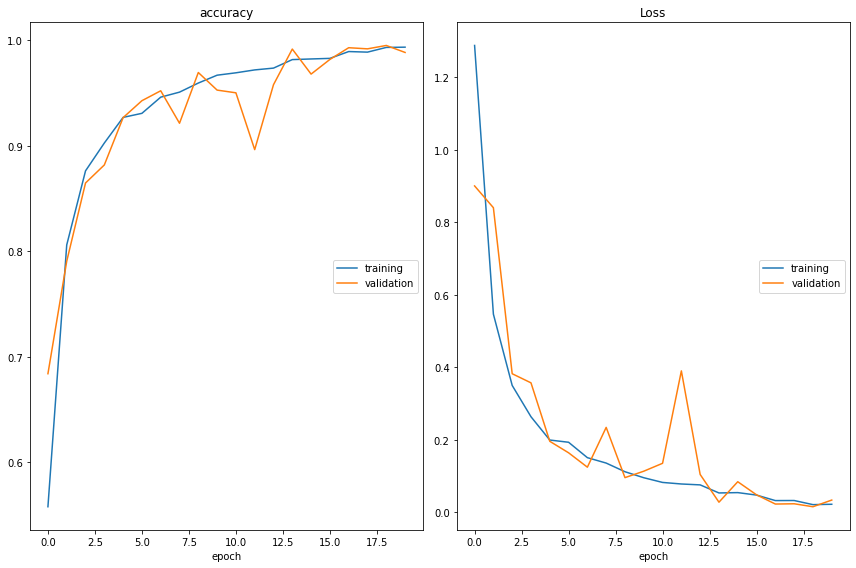

accuracy
	training         	 (min:    0.558, max:    0.993, cur:    0.993)
	validation       	 (min:    0.684, max:    0.995, cur:    0.988)
Loss
	training         	 (min:    0.021, max:    1.288, cur:    0.022)
	validation       	 (min:    0.016, max:    0.900, cur:    0.034)
Training complete in 18m 46s
Best val Acc: 0.995085


In [24]:
from PIL import Image
model, best_acc = train_model(batch_size, n_epochs, learningRate, 
                model, dataset_sizes, cost_function, optimizer, exp_lr_scheduler, 
                dataloaders);

# Output the weights with best accuracy in validation dataset

In [25]:
torch.save(model.state_dict(), '/content/drive/Shareddrives/COMP576/model_weights_aug.pth')

In [26]:
test_set.to_csv("/content/drive/Shareddrives/COMP576/test_data_aug.csv", header=True, index=False)